In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.layers import Activation, Flatten, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from sklearn.metrics import mean_squared_error
import tensorflow as tf
tf.keras.regularizers.l2(l=0.01)
tf.keras.regularizers.l1(l=0.01)
%matplotlib inline
np.random.seed(45)

In [57]:
# Reading the dataset

data = pd.read_csv('NYSE-Composite Index.csv')
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-02,641.719971,641.719971,641.719971,641.719971,641.719971,0
1,1980-01-03,638.020020,638.020020,638.020020,638.020020,638.020020,0
2,1980-01-04,646.799988,646.799988,646.799988,646.799988,646.799988,0
3,1980-01-07,649.229980,649.229980,649.229980,649.229980,649.229980,0
4,1980-01-08,661.809998,661.809998,661.809998,661.809998,661.809998,0


In [58]:
# Dropping irrelevant columns

data = data.drop(columns=['Date','Adj Close','Volume'])
data.head()

,Open,High,Low,Close
0,641.719971,641.719971,641.719971,641.719971
1,638.020020,638.020020,638.020020,638.020020
2,646.799988,646.799988,646.799988,646.799988
3,649.229980,649.229980,649.229980,649.229980
4,661.809998,661.809998,661.809998,661.809998


In [59]:
print(data.shape)

(10576, 4)


In [60]:
# Scaling the data values, scaler_pred is for inverse scaling purposes

scaler_pred = MinMaxScaler(feature_range=(0, 1))
df_Close = pd.DataFrame(data['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

y_close = data[:,3]
y_close.shape

(10576,)

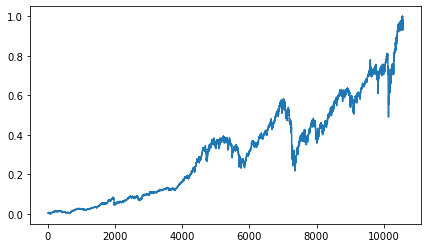

In [62]:
# Plotting normalized data

plt.figure(figsize=(7,4))
plt.plot(y_close)
plt.show()

In [63]:
#splitting dataset into train and test split

train_size = int(len(data) * 0.75)
test_size = len(data)-train_size
train_data = data[0:train_size]
test_data = data[train_size:len(data)]

y_close_train = y_close[0:train_size]
y_close_test  = y_close[train_size:len(y_close)]

In [64]:
# Checking shape of training and testing data

print(train_size)
print(train_data.shape)
print(test_data.shape)

7932
(7932, 4)
(2644, 4)


In [65]:
# Function for creating time sequences

def create_timeseries(seq_size, data, close):
    
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        
        window = data[i:(i+seq_size)]
        after_window = close[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [66]:
# Creating time sequences

time_step = 10
X_train, y_train = create_timeseries(time_step, train_data, y_close_train)
X_test, y_test   = create_timeseries(time_step, test_data, y_close_test)

print("Shape of x_train: {}".format(X_train.shape))
print("Shape of x_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (7921, 10, 1, 4)
Shape of x_test: (2633, 10, 1, 4)
Shape of y_train: (7921,)
Shape of y_test: (2633,)


In [67]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[3]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[3])     


In [68]:
# Checking shapes

print(X_train.shape)
print(X_test.shape)

(7921, 10, 4)
(2633, 10, 4)


In [14]:
#---------------------  Stacked LSTM model  -----------------------------------


In [15]:
# Create LSTM Model

lstm = Sequential()
lstm.add(LSTM(64, input_shape=(time_step, 4), return_sequences = True))
lstm.add(LSTM(32, return_sequences= True))
lstm.add(LSTM(32, return_sequences= True))
lstm.add(LSTM(16))
lstm.add(Dense(1, activation = 'linear'))

In [16]:
# Model Compiling and training

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=2)


Epoch 1/100
50/50 - 26s - loss: 0.0043 - val_loss: 8.2923e-04
Epoch 2/100
50/50 - 3s - loss: 5.4411e-05 - val_loss: 3.5308e-04
Epoch 3/100
50/50 - 3s - loss: 3.2913e-05 - val_loss: 5.0190e-04
Epoch 4/100
50/50 - 3s - loss: 3.0998e-05 - val_loss: 5.2475e-04
Epoch 5/100
50/50 - 3s - loss: 3.0524e-05 - val_loss: 5.6818e-04
Epoch 6/100
50/50 - 3s - loss: 3.0802e-05 - val_loss: 5.0668e-04
Epoch 7/100
50/50 - 3s - loss: 3.1134e-05 - val_loss: 5.1495e-04
Epoch 8/100
50/50 - 3s - loss: 3.0602e-05 - val_loss: 6.5970e-04
Epoch 9/100
50/50 - 3s - loss: 3.0799e-05 - val_loss: 5.0168e-04
Epoch 10/100
50/50 - 3s - loss: 3.0105e-05 - val_loss: 5.5472e-04
Epoch 11/100
50/50 - 3s - loss: 3.1656e-05 - val_loss: 6.6359e-04
Epoch 12/100
50/50 - 3s - loss: 3.0387e-05 - val_loss: 4.7891e-04
Epoch 13/100
50/50 - 3s - loss: 3.1948e-05 - val_loss: 5.3547e-04
Epoch 14/100
50/50 - 3s - loss: 3.2155e-05 - val_loss: 3.8685e-04
Epoch 15/100
50/50 - 3s - loss: 3.1124e-05 - val_loss: 3.9699e-04
Epoch 16/100
50/50 - 3

In [17]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 41,553
Trainable params: 41,553
Non-trainable params: 0
_________________________________________________________________


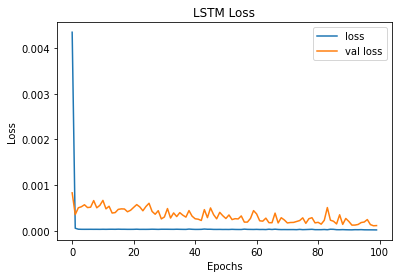

In [18]:
# Plotting training and validation losses

plt.plot(lstm.history.history['loss'], label = 'loss')
plt.plot(lstm.history.history['val_loss'], label = 'val loss')
plt.title('LSTM Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [19]:
# Predictions using trained lstm model

lstmtrainPredict = lstm.predict(X_train)
lstmtestPredict = lstm.predict(X_test)

In [20]:
# Inverse Scaling for plotting and RMSE calculations

lstmtrainPredict = scaler_pred.inverse_transform(lstmtrainPredict)
y_train_lstm = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
lstmtestPredict = scaler_pred.inverse_transform(lstmtestPredict)
y_test_lstm = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Training RMSE

train_rmse = np.sqrt(mean_squared_error(y_train_lstm, lstmtrainPredict))
print('Train RMSE: %.2f' % (train_rmse))

Train RMSE: 101.67


In [22]:
# Test RMSE

test_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstmtestPredict))
print('Test RMSE: %.2f' % (test_rmse))

Test RMSE: 648.89


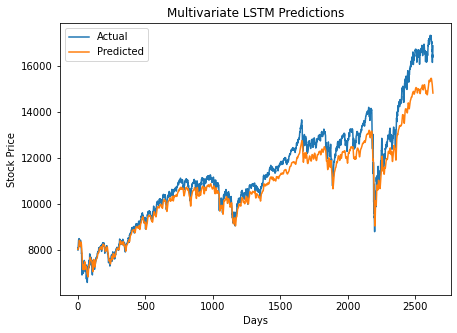

In [23]:
# Plotting actual vs predicted prices

plt.figure(figsize=(7,5))
plt.plot(y_test_lstm, label = 'Actual')
plt.plot(lstmtestPredict,label = 'Predicted')
plt.title('Multivariate LSTM Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [69]:
#----------------------------- CNN Model-----------------------------------------------

In [70]:
# Checking shape of training data

print(X_train.shape)
print(X_test.shape)

(7921, 10, 4)
(2633, 10, 4)


In [71]:
# Reshape input to that which is required for CNN

X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])  
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])   

print(X_train.shape)
print(X_test.shape)

(7921, 1, 10, 4)
(2633, 1, 10, 4)


In [72]:
cnn = Sequential()
cnn.add(Conv2D(8, kernel_size = (1, 2), strides = (1, 1),  padding = 'valid', 
               activation = 'relu', input_shape = (1,10,4)))
cnn.add(MaxPooling2D(pool_size = (1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation="relu"))
cnn.summary()   

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 9, 8)           72        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,249
Trainable params: 2,249
Non-trainable params: 0
____________________________________________________

In [73]:
cnn.compile(loss='mean_squared_error', optimizer='adam')

In [74]:
cnn.fit(X_train,y_train, validation_split=0.2,batch_size = 128, verbose=1,epochs = 100)

Epoch 1/100
50/50 [==============================] - 4s 56ms/step - loss: 0.0138 - val_loss: 0.0021
Epoch 2/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 9.0375e-04
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.7294e-04
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 7.8229e-04
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 5.5709e-04
Epoch 8/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 3.9446e-04
Epoch 9/100
50/50 [==============================] - 0s 7ms/step - loss: 9.8668e-04 - val_loss: 5.9579e-04
Epoch 10/100
50/50 [==============================] - 0s 7ms/step - loss: 9.707

50/50 [==============================] - 0s 8ms/step - loss: 7.9686e-04 - val_loss: 2.9668e-04
Epoch 78/100
50/50 [==============================] - 0s 8ms/step - loss: 8.0182e-04 - val_loss: 2.2891e-04
Epoch 79/100
50/50 [==============================] - 0s 7ms/step - loss: 7.5818e-04 - val_loss: 5.1199e-04
Epoch 80/100
50/50 [==============================] - 0s 7ms/step - loss: 7.6482e-04 - val_loss: 1.9447e-04
Epoch 81/100
50/50 [==============================] - 0s 7ms/step - loss: 7.9925e-04 - val_loss: 4.5709e-04
Epoch 82/100
50/50 [==============================] - 0s 8ms/step - loss: 7.6039e-04 - val_loss: 3.6351e-04
Epoch 83/100
50/50 [==============================] - 0s 7ms/step - loss: 7.8230e-04 - val_loss: 5.9289e-04
Epoch 84/100
50/50 [==============================] - 0s 7ms/step - loss: 7.7755e-04 - val_loss: 3.8479e-04
Epoch 85/100
50/50 [==============================] - 0s 7ms/step - loss: 7.6538e-04 - val_loss: 7.6643e-04
Epoch 86/100
50/50 [=====================

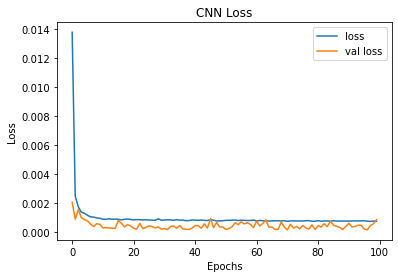

In [75]:
# Plotting training and validation losses

plt.plot(cnn.history.history['loss'], label = 'loss')
plt.plot(cnn.history.history['val_loss'], label = 'val loss')
plt.title('CNN Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [76]:
# Predictions using trained cnn model

cnntrainPredict = cnn.predict(X_train)
cnntestPredict = cnn.predict(X_test)

In [77]:
# Reverse scaling for plotting and rmse

cnntrainPredict = scaler_pred.inverse_transform(cnntrainPredict)
y_train_cnn = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
cnntestPredict = scaler_pred.inverse_transform(cnntestPredict)
y_test_cnn = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [78]:
# Training RMSE

train_rmse = np.sqrt(mean_squared_error(y_train_cnn, cnntrainPredict))
print('Train RMSE: %.2f' % (train_rmse))

Train RMSE: 311.29


In [79]:
# Test RMSE

test_rmse = np.sqrt(mean_squared_error(y_test_cnn, cnntestPredict))
print('Test RMSE: %.2f' % (test_rmse))

Test RMSE: 1074.70


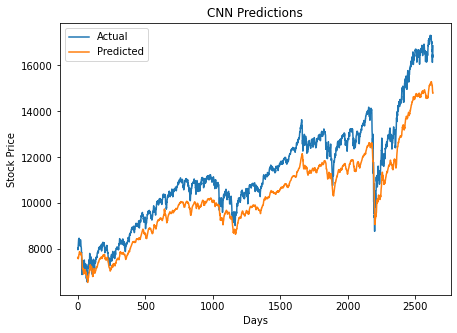

In [80]:
# Plotting actual vs predicted prices

plt.figure(figsize=(7,5))
plt.plot(y_test_cnn, label = 'Actual')
plt.plot(cnntestPredict,label = 'Predicted')
plt.title('CNN Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [36]:
#-----------------------  CNN-LSTM model -----------------------------------------------

In [37]:
# Checking shape

print(X_train.shape)

(7921, 1, 10, 4)


In [38]:
# Create CNN-LSTM Model

cnn_lstm = tf.keras.Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, 10, 4))))
cnn_lstm.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(Bidirectional(LSTM(100, return_sequences=True)))
cnn_lstm.add(Dropout(0.25))
cnn_lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
cnn_lstm.add(Dropout(0.5))
cnn_lstm.add(Dense(1, activation='linear'))
cnn_lstm.compile(optimizer='adam', loss='mse')

In [39]:
# Training the model 

cnn_lstm.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
50/50 [==============================] - 29s 169ms/step - loss: 0.0075 - val_loss: 7.7290e-04
Epoch 2/100
50/50 [==============================] - 1s 26ms/step - loss: 4.1380e-04 - val_loss: 2.2183e-04
Epoch 3/100
50/50 [==============================] - 2s 33ms/step - loss: 3.8190e-04 - val_loss: 1.9912e-04
Epoch 4/100
50/50 [==============================] - 1s 25ms/step - loss: 3.1924e-04 - val_loss: 1.9027e-04
Epoch 5/100
50/50 [==============================] - 2s 38ms/step - loss: 3.3452e-04 - val_loss: 2.0113e-04
Epoch 6/100
50/50 [==============================] - 1s 24ms/step - loss: 3.0765e-04 - val_loss: 2.5249e-04
Epoch 7/100
50/50 [==============================] - 1s 24ms/step - loss: 2.8207e-04 - val_loss: 2.0007e-04
Epoch 8/100
50/50 [==============================] - 1s 25ms/step - loss: 2.7509e-04 - val_loss: 2.0410e-04
Epoch 9/100
50/50 [==============================] - 2s 33ms/step - loss: 2.5607e-04 - val_loss: 4.3238e-04
Epoch 10/100
50/50 [==========

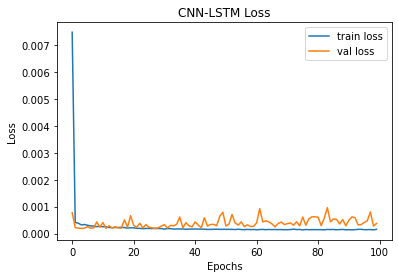

In [40]:
# Plotting training and validation losses

plt.plot(cnn_lstm.history.history['loss'], label='train loss')
plt.plot(cnn_lstm.history.history['val_loss'], label='val loss')
plt.title('CNN-LSTM Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [41]:
# Predictions using trained cnn-lstm model

trainPredict = cnn_lstm.predict(X_train)
testPredict = cnn_lstm.predict(X_test)

In [42]:
# Reverse scaling for plotting and rmse

cnnlstm_trainPredict = scaler_pred.inverse_transform(trainPredict)
y_train_cnnlstm = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
cnnlstm_testPredict = scaler_pred.inverse_transform(testPredict)
y_test_cnnlstm = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [43]:
# Training RMSE

train_rmse = np.sqrt(mean_squared_error(y_train_cnnlstm, cnnlstm_trainPredict))
print('Train RMSE: %.2f' % (train_rmse))

Train RMSE: 165.06


In [44]:
# Test RMSE

test_rmse = np.sqrt(mean_squared_error(y_test_cnnlstm, cnnlstm_testPredict))
print('Test RMSE: %.2f' % (test_rmse))

Test RMSE: 1565.51


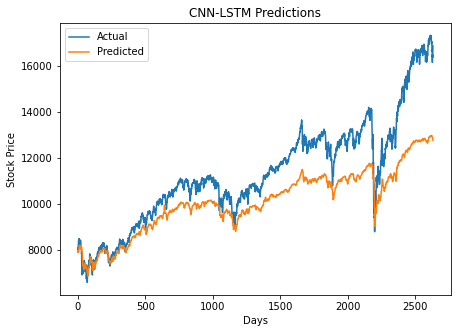

In [45]:
# Plotting actual vs predicted prices

plt.figure(figsize=(7,5))
plt.plot(y_test_cnnlstm, label = 'Actual')
plt.plot(cnnlstm_testPredict,label = 'Predicted')
plt.title('CNN-LSTM Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [46]:
#-------------------  GRU Model  --------------------------------------------

In [47]:
# Checking shape of training data

X_train.shape

(7921, 1, 10, 4)

In [48]:
# reshape input to be suitable for GRU

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])    

In [49]:
# Create GRU Model

gru = Sequential()
gru.add(GRU(units=50, return_sequences=True, input_shape=(10, 4), activation='tanh'))
gru.add(GRU(units=50, return_sequences=True, input_shape=(10, 4), activation='tanh'))
gru.add(Dropout(0.2))
gru.add(GRU(units=50, activation='tanh'))
gru.add(Dropout(0.2))
gru.add(Dense(units=1))

In [50]:
# Compile and train model

gru.compile(optimizer=SGD(learning_rate = 0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
gru.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
50/50 [==============================] - 22s 114ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 2/100
50/50 [==============================] - 3s 56ms/step - loss: 7.7530e-04 - val_loss: 2.1491e-04
Epoch 3/100
50/50 [==============================] - 3s 56ms/step - loss: 5.4268e-04 - val_loss: 3.3160e-04
Epoch 4/100
50/50 [==============================] - 3s 56ms/step - loss: 4.9829e-04 - val_loss: 1.8770e-04
Epoch 5/100
50/50 [==============================] - 3s 55ms/step - loss: 4.5908e-04 - val_loss: 1.9983e-04
Epoch 6/100
50/50 [==============================] - 3s 55ms/step - loss: 4.3626e-04 - val_loss: 2.2628e-04
Epoch 7/100
50/50 [==============================] - 3s 56ms/step - loss: 4.2139e-04 - val_loss: 1.8600e-04
Epoch 8/100
50/50 [==============================] - 3s 56ms/step - loss: 4.1550e-04 - val_loss: 1.5920e-04
Epoch 9/100
50/50 [==============================] - 3s 56ms/step - loss: 3.8352e-04 - val_loss: 1.3570e-04
Epoch 10/100
50/50 [==============

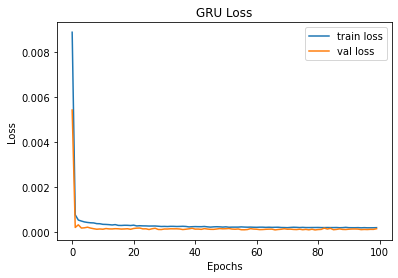

In [51]:
# Plotting training and validation losses

plt.plot(gru.history.history['loss'], label='train loss')
plt.plot(gru.history.history['val_loss'], label='val loss')
plt.title('GRU Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [52]:
# Predictions using trained gru model

gru_trainPredict = gru.predict(X_train)
gru_testPredict = gru.predict(X_test)

In [53]:
# Rescale for plotting 

gru_trainPredict = scaler_pred.inverse_transform(gru_trainPredict)
y_train_gru = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
gru_testPredict = scaler_pred.inverse_transform(gru_testPredict)
y_test_gru = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [54]:
# Training RMSE

train_rmse = np.sqrt(mean_squared_error(y_train_gru, gru_trainPredict))
print('Train RMSE: %.2f' % (train_rmse))

Train RMSE: 115.76


In [55]:
# Test RMSE

test_rmse = np.sqrt(mean_squared_error(y_test_gru, gru_testPredict))
print('Test RMSE: %.2f' % (test_rmse))

Test RMSE: 414.53


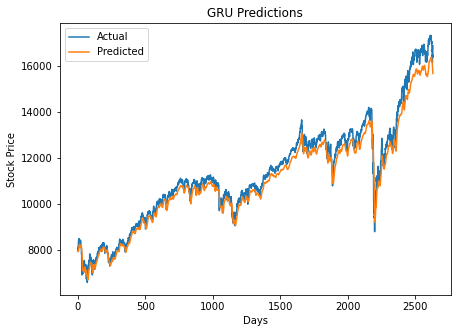

In [56]:
# Plotting actual vs predicted prices

plt.figure(figsize=(7,5))
plt.plot(y_test_gru, label = 'Actual')
plt.plot(gru_testPredict,label = 'Predicted')
plt.title('GRU Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()